In [81]:
import os
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from torch.utils.data import Dataset, DataLoader
import glob

In [82]:
class PlantSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, '*.jpg')))

        print(f"Number of images: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [83]:
train_root_dir = "/Users/shilo/Documents/GitHub/BiomassPredictonAI/image_data/masks/T03_rgb/"

train_transforms = transforms.Compose([
    #transforms.Resize((2048,1024)),
    transforms.ToTensor()
])

train_dataset = PlantSegmentationDataset(root_dir=train_root_dir, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

Number of images: 31


In [84]:
sam_checkpoint = '../BiomassPredictonAI/checkpoints/sam_checkpoints/sam_vit_l_0b3195.pth'
model_type = "vit_l" #
device = "cpu" #cpu,cuda

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator1 = SamAutomaticMaskGenerator(sam, points_per_batch=16)
predictor = SamPredictor(sam)

(1080, 1920, 3)


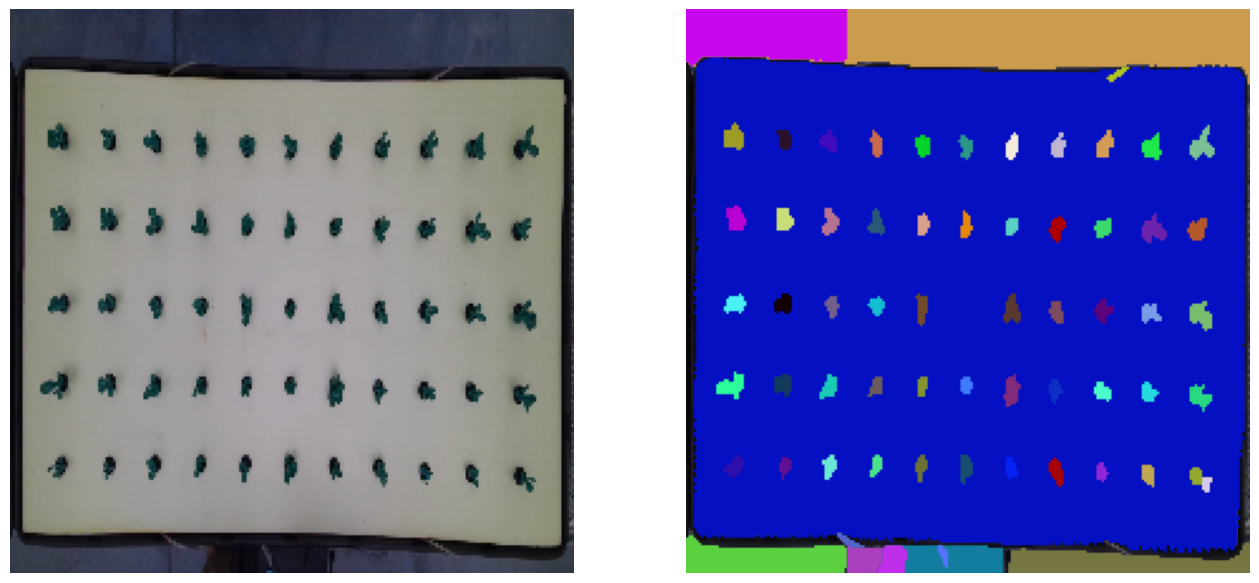

In [85]:
import random

import numpy as np

def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m**0.5)))

num_images = 10
random_indices = random.sample(range(len(train_dataset)), num_images)
image_tensor= train_dataset[0]
image_path = "../BiomassPredictonAI/image_data/masks/T03_rgb/T03_GH13_JC01_Feb-01-2023_0816_rgb.jpg"
image_information = cv2.imread(image_path)
image = cv2.resize(image_information, (224,224))
masks = mask_generator1.generate(image)


image_np = image_tensor.numpy()
# Reshape the image data to a valid shape
image_data = np.moveaxis(image_np, 0, -1)  # Move the channels axis to the last position
print(image_data.shape)  # Output: (256, 256, 3)
# Plot the original image and the mask


# Plot the original image and the mask
fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs[0].imshow(image)
axs[1].imshow(image)
show_anns(masks, axs[1])
axs[0].axis('off')
axs[1].axis('off')
plt.show()